Omer Dor - ID: 207828120 , Eldor Mouyal - ID: 207352451 , Saja Jbareen - ID: 207929761

In [ ]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
from ipywidgets import interact, widgets, Layout, fixed
%matplotlib inline

# Question 1 - Edge detection

## Section B

In [ ]:
def zero_crossing(LoG, a, b):
    """
    This function gets as input the LoG and calculates the zero crossings.
    The output is a binary matrix with 1 in all the zero crossing pixels
    and 0 otherwise.
    """
    height = LoG.shape[0]
    width = LoG.shape[1]
    crossings_matrix = np.zeros_like(LoG)

    for y in range(0 , height-1):
      for x in range(0, width-1):
        if LoG[y][x] > a:
          for xPrime, yPrime in eight_env(x, y):
            if 0 <= xPrime < width and 0 <= yPrime < height:
              if b > LoG[yPrime][xPrime]:
                crossings_matrix[y][x] = 1
                break
            elif LoG[y][x] < b:
              for xPrime, yPrime in eight_env(x, y):
                if 0 <= xPrime < width and 0 <= yPrime < height:
                  if LoG[yPrime][xPrime] > a:
                    crossings_matrix[y][x] = 1
                    break
    return crossings_matrix # Replace with zero crossing code

def eight_env(x, y):
  return [[x-1, y], [x-1, y-1], [x, y-1], [x+1, y-1],
          [x+1, y], [x+1, y+1], [x, y+1], [x-1, y+1]];

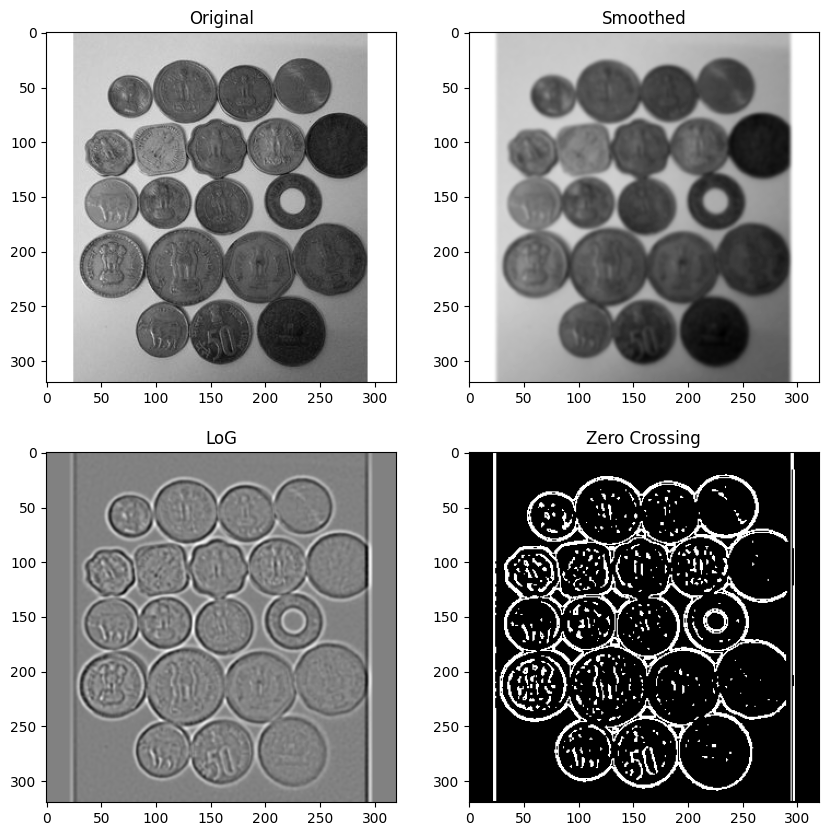

In [ ]:
# Reads the original image in grayscale, and sets the image range to be 0-1 (instead of 0-255)
coins = cv2.imread('coins_edges.jpg', cv2.IMREAD_GRAYSCALE).astype(float) / 255 #'coins': The original image in grayscale.

## Implementation of LoG as shown in tutorial #6
laplacian_kernel = np.array([
    [0, -1,  0],
    [-1, 4, -1],
    [0, -1,  0],
])
# 'smoothed': The smoothed image (i.e., the image after applying the Gaussian smoothing).
smoothed = cv2.GaussianBlur(coins, (7, 7) ,0) # You may change the 'ksize' parameter (7,7) and the sigma parameter 0.
LoG = cv2.filter2D(smoothed, ddepth=cv2.CV_64F, kernel=laplacian_kernel).astype(float) #'LoG': The image after applying LoG.

# 'zc': The image of the detected edges after applying zero-crossing.
zc = zero_crossing(LoG,
                   a = 0.01,
                   b = 0.02) # You may change the parameters a, b to get the best result///////////


# Showing the 4 plots requested in this section
_, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, img ,title in zip(axes.flatten(),
                          [coins, smoothed, LoG, zc],
                          ["Original", "Smoothed", "LoG", "Zero Crossing"]):
    ax.imshow(img,
              cmap='gray')
    ax.set_title(title)


## Section C

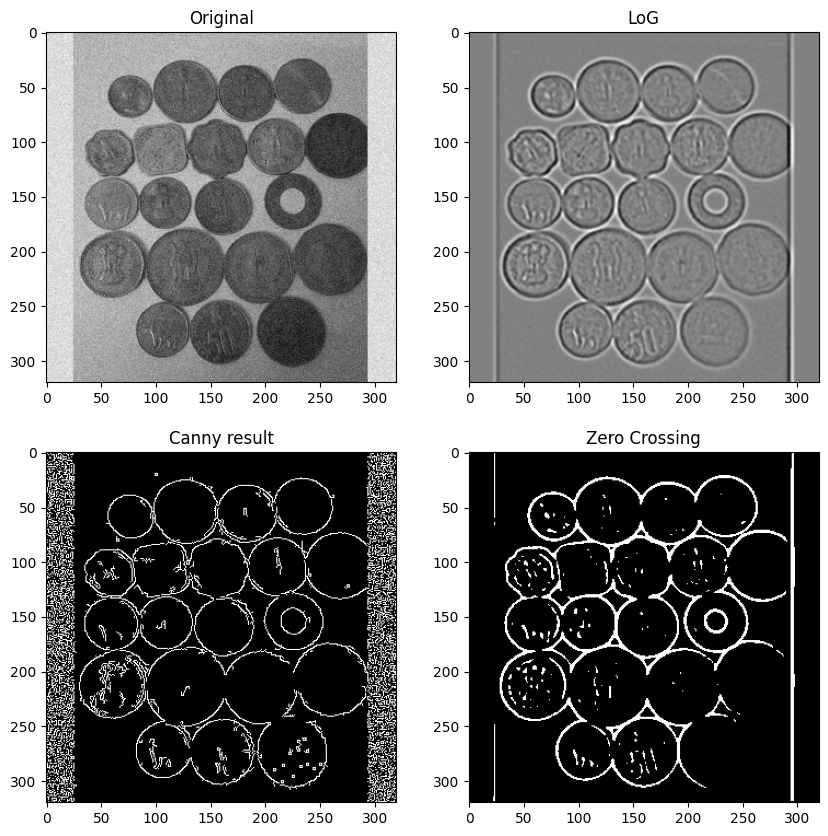

In [ ]:
# coins' image with added Gaussian noise
noisy_coins = coins + np.random.standard_normal(coins.shape) * 0.05

smoothed_noise = cv2.GaussianBlur(noisy_coins, (7, 7) ,0) # You may change the 'ksize' parameter (7,7) and the sigma parameter 0.
LoG_noise = cv2.filter2D(smoothed, ddepth=cv2.CV_64F, kernel=laplacian_kernel).astype(float) #'LoG': The image after applying LoG.
zc_noise = zero_crossing(LoG,
                           a= 0.02,
                           b = 0.06)
# OpenCV expects image with value range of 0 - 255
# Therefore, for cv2 functions (such as cv2.Canny) use the following variable instead of 'noisy_coins'
noisy_coins_uint8 = (noisy_coins * 255).astype(np.uint8)

#=============
# Find edges in the noisy image by using
# cv2.Canny and your method from section A. Plot the results side by side.
#low_t=widgets.IntSlider(min=140,max=255,step=10,value=1, layout=Layout(width='100%'))
low_t = 130
cannyResult = cv2.Canny(noisy_coins_uint8, low_t, 3 * low_t)
# Showing the 4 plots requested in this section
_, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, img ,title in zip(axes.flatten(),
                          [noisy_coins, LoG_noise, cannyResult, zc_noise],
                          ["Original", "LoG", "Canny result", "Zero Crossing"]):
    ax.imshow(img,
              cmap='gray')
    ax.set_title(title)

# Question 3 - Hough Transform

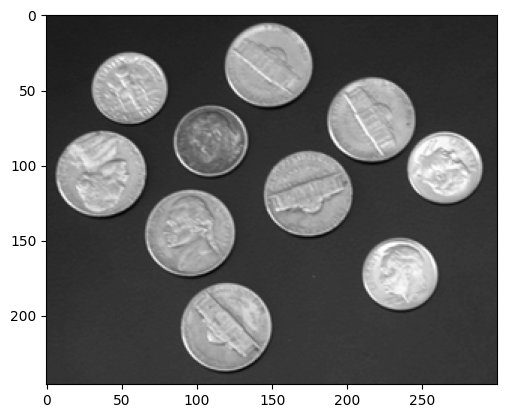

In [ ]:
# Step 0: Read the image in grayscale
img = cv2.imread('coins_Hough.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

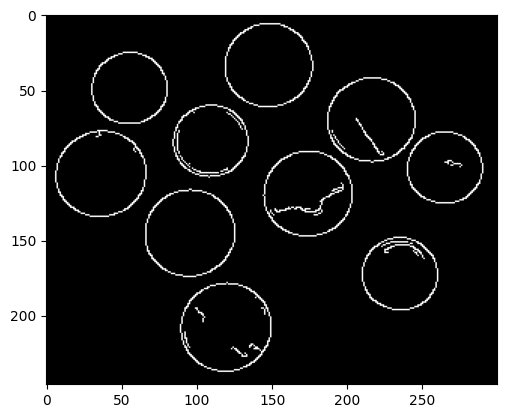

In [ ]:
def edgeDetector(image):
  # Step 2: Find edge pixels using an edge detector
  t1 = 150
  t2 = 3 * t1
  edges = cv2.Canny(img, threshold1=t1, threshold2=t2)
  return edges

# Step 1: Produce an edge map from the image using an edge detector
edges = edgeDetector(img)
plt.imshow(edges, cmap='gray')

In [ ]:
def HoughCircles(edge_map):
  '''
  This function should get as input binary edge map and any additional
  parameters needed to compute the Hough space and to find the local maximums.
  It should first compute the Hough space, i.e. the votes of each edge pixel
  for all the relevant circles passing by it. Then, it should detect the local
  maximum points which are equivalent to detecting the circles in the image.
  The algorithm should return the parameters representing the detected circles.
  Note: you must explain any additional input and\or output parameters to this algorithm
  in your attached pdf file.
  '''
  picWidth , picHeight = edge_map.shape[:2]

  min_radius = 10
  max_radius = min(picWidth, picHeight) // 2 #integer division
  #CXs = np.arange(0, picWidth, step=1)
  #CYs = np.arange(0, picHeight, step=1)
  Rs = np.arange(min_radius, max_radius + 1, step =1)

  accumulator = np.zeros((len(Rs), picHeight, picWidth), dtype = int)
  for y in range(picHeight):
    for x in range(picWidth):
      if edge_map[x][y] != 0:
        for r_idx, radius in enumerate(Rs):
          for theta in range(360):
            cx = int(x - radius * np.sin(np.radians(theta))) #///// might change later
            cy = int(y - radius * np.cos(np.radians(theta)))
            if 0 <= cx < picWidth and 0 <= cy < picHeight:
              accumulator[r_idx, cy, cx] += 1

  detected_circles = []
  threshold = np.max(accumulator) * 0.8 # set a threshold for considering a local maximum
  for r_idx, radius in enumerate(Rs):
    for y in range(picHeight):
      for x in range(picWidth):
        if accumulator[r_idx, y, x] >= threshold:
                    # Check if the point is a local maximum
                    is_max = True
                    for dy in range(-1, 2):
                        for dx in range(-1, 2):
                            if (dy != 0 or dx != 0) and (0 <= y + dy < picHeight) and (0 <= x + dx < picWidth):
                                if accumulator[r_idx, y, x] < accumulator[r_idx, y + dy, x + dx]:
                                    is_max = False
                                    break
                        if not is_max:
                            break
                    if is_max:
                        detected_circles.append((x, y, radius))

  #========
  return detected_circles

# Step 2: Detect circles in the image using Hough transform
detected_circles = HoughCircles(edges)

In [ ]:
print(detected_circles)

[(82, 109, 23), (48, 55, 24), (83, 109, 24), (172, 235, 24), (101, 264, 24), (101, 265, 24), (49, 55, 25), (33, 148, 28), (69, 217, 28), (105, 36, 29), (145, 94, 29), (208, 118, 29), (207, 120, 29), (34, 147, 29), (119, 173, 29), (70, 216, 29), (146, 95, 30), (208, 119, 30)]


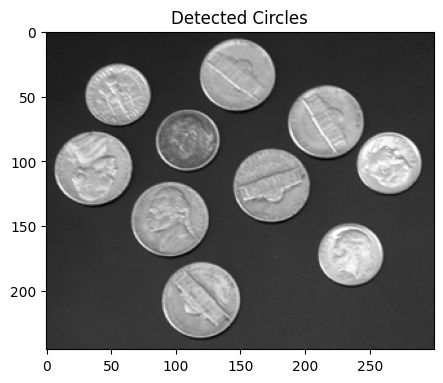

In [ ]:
def plotCircles(image):
  '''
  This function should plot the detected circles.
  It should draw the circles on top of the original grayscale image.
  You must add to this function parameters representing the detected circles
  that should be drawn.
  '''
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  ax.imshow(image, cmap="gray")
  ax.title.set_text("Detected Circles")

  #=======
  # add your code to draw and plot circles
  for cx, cy, radius in detected_circles:
    ax.add_patch = Circle((cx, cy), radius, color = 'blue', fill = False)
  plt.show()
  #=======


# Step 3: Plot the detected circles on top of the original image
plotCircles(img)

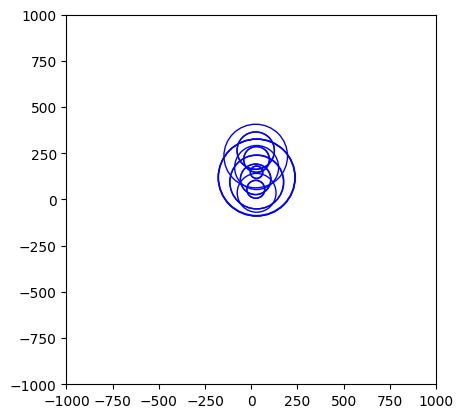

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each circle
for circle in detected_circles:
    radius = circle[0]
    y_center = circle[1]
    x_center = circle[2]
    circle_plot = plt.Circle((x_center, y_center), radius, fill=False, edgecolor='b')
    ax.add_patch(circle_plot)

# Set axis limits (optional, adjust as needed)
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)

# Set aspect ratio to 'equal' to ensure circles are not distorted
ax.set_aspect('equal', adjustable='box')

# Show the plot
plt.show()
